<a href="https://colab.research.google.com/github/xian51/sit742/blob/main/XIAN_ZHU_MIS780A2PartB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIS780 Advanced AI For Business - Assignment 2 - T2 2021

## Part B:  Deep Learning for Image Data

**Student Name:** Xian Zhu

**Student ID:** 215453182

In [ ]:
%%html
<style>table {float:left}</style>
<style>img {float:left}</style>

## Table of Content
   
1. [Notebook Preparation](#cell_Preparation)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Model Construction](#cell_model)

4. [Model Execution](#cell_execution)
 
5. [Experiments Report](#cell_report)



<a id = "cell_Preparation"></a>
## 1. Notebook Preparation

All required Python libraries are loaded.

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D,add
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, RMSprop, Adadelta, Adam, Nadam
from tensorflow.keras.losses import categorical_crossentropy

Common functions are defined.

In [ ]:
def plot_images(ims, figsize=(12,12), cols=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        if (ims.shape[-1] != 3):
            ims = ims = ims[:,:,:,0]
    f = plt.figure(figsize=figsize)
    rows=len(ims)//cols if len(ims) % cols == 0 else len(ims)//cols + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [ ]:
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]
    
    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()
    
    return

In [ ]:
def rmse_images(images1, images2):
    return math.sqrt(np.square(np.subtract(images1, images2)).mean())

def mae_images(images1, images2):
    return np.abs(np.subtract(images1, images2)).mean()

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

In [ ]:
from tensorflow.keras.datasets import cifar10

# Data parameters
img_rows, img_cols = 32, 32
channels = 3


# the data, shuffled and split between train and test sets
(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

170508288/170498071 [==============================] - 11s 0us/step


*Inject noise into all images (both training and testing). with noice factor = 0.3*

In [ ]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Show original images and noisy images.

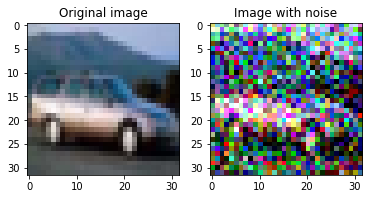

In [ ]:
idx = 4
plt.subplot(1,2,1)
plt.imshow(x_train[idx])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(x_train_noisy[idx])
plt.title('Image with noise')
plt.show()

<a id = "cell_model"></a>
## 3. Model Construction

Show the shape the image

In [ ]:
img_rows = 32
img_cols = 32
channels = 3

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, channels)

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Model 1: 2 convolutional layers for encoding, 2 convolutional layers for decoding. BatchNormalization is used for each layer, and use leakrelu activation.

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())     # 32x32x32
model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))      # 16x16x32
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 16x16x32
model.add(BatchNormalization())     # 16x16x32
model.add(UpSampling2D())
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 32x32x32
model.add(BatchNormalization())
model.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))   # 32x32x3

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)       

Model 2: 3 convolutional layers with dropout and maxpooling for encoding, 3 convolutional layers with dropout for decoding. BatchNormalization is used for each layer, and use leakrelu activation.

In [ ]:
# Encoder 
inputs = Input(shape=(32,32,3))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Dropout(0.5)(x)
skip = Conv2D(32, 3, padding='same')(x)
x = LeakyReLU()(skip)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Dropout(0.5)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D()(x)

# Decoder
x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, padding='same')(x)
x = add([x,skip])
x = LeakyReLU()(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)

autoencoder = Model(inputs, decoded)

autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 32, 32, 32)   896         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 32, 32, 32)   128         conv2d_27[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 16, 16, 32)   0           batch_normalization_37[0][0]     
____________________________________________________________________________________________

<a id = "cell_execution"></a>
## 4. Model Execution

**Model 1**

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=0)]

opt_rmsprop = RMSprop(learning_rate=0.1)

model.compile(optimizer=opt_rmsprop, loss='binary_crossentropy')
hist6 = model.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=callbacks)

Epoch 1/100
391/391 [==============================] - 14s 33ms/step - loss: 0.5900 - val_loss: 1.2064
Epoch 2/100
391/391 [==============================] - 12s 32ms/step - loss: 0.5758 - val_loss: 0.9020
Epoch 3/100
391/391 [==============================] - 12s 31ms/step - loss: 0.5740 - val_loss: 0.6011
Epoch 4/100
391/391 [==============================] - 12s 31ms/step - loss: 0.5747 - val_loss: 0.5761
Epoch 5/100
391/391 [==============================] - 12s 31ms/step - loss: 0.5753 - val_loss: 0.5721
Epoch 6/100
391/391 [==============================] - 12s 31ms/step - loss: 0.5724 - val_loss: 0.5859
Epoch 7/100
391/391 [==============================] - 12s 31ms/step - loss: 0.5735 - val_loss: 0.5684
Epoch 8/100
391/391 [==============================] - 12s 31ms/step - loss: 0.5750 - val_loss: 0.5853
Epoch 9/100
391/391 [==============================] - 12s 31ms/step - loss: 0.5734 - val_loss: 0.5715
Epoch 10/100
391/391 [==============================] - 12s 31ms/step - l

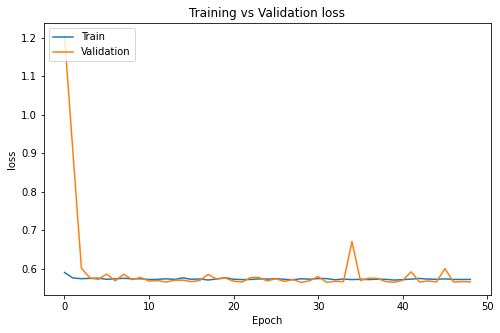

In [ ]:
plot_hist(hist6.history, xsize=8, ysize=5)

The loss curve shows that there is minimal difference between train and validation.

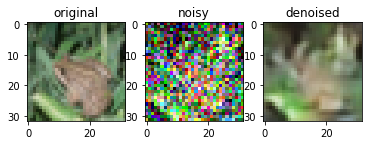

In [ ]:
decoded_noisy_imgs3 = model.predict(x_test_noisy)

idx = 4
plt.subplot(1,3,1)
plt.imshow(x_test[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(x_test_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(decoded_noisy_imgs3[idx])
plt.title('denoised')
plt.show()

In [ ]:
print('Original vs noisy MAE = \t', round(mae_images(x_test, x_test_noisy), 5))
print('Original vs denoised MAE = \t', round(mae_images(x_test, decoded_noisy_imgs3), 5))

Original vs noisy MAE = 	 0.20257
Original vs denoised MAE = 	 0.06139


**Model 2**

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=0)]

opt_adam = Adam(learning_rate=0.001)

autoencoder.compile(optimizer=opt_adam, loss='binary_crossentropy')
hist2 = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=callbacks)

Epoch 1/100
196/196 [==============================] - 10s 46ms/step - loss: 0.5703 - val_loss: 0.5674
Epoch 2/100
196/196 [==============================] - 9s 44ms/step - loss: 0.5703 - val_loss: 0.5675
Epoch 3/100
196/196 [==============================] - 9s 44ms/step - loss: 0.5703 - val_loss: 0.5675
Epoch 4/100
196/196 [==============================] - 9s 44ms/step - loss: 0.5703 - val_loss: 0.5674
Epoch 5/100
196/196 [==============================] - 9s 44ms/step - loss: 0.5703 - val_loss: 0.5673
Epoch 6/100
196/196 [==============================] - 9s 44ms/step - loss: 0.5702 - val_loss: 0.5674
Epoch 7/100
196/196 [==============================] - 9s 44ms/step - loss: 0.5702 - val_loss: 0.5673
Epoch 8/100
196/196 [==============================] - 9s 44ms/step - loss: 0.5702 - val_loss: 0.5673
Epoch 9/100
196/196 [==============================] - 8s 43ms/step - loss: 0.5702 - val_loss: 0.5675
Epoch 10/100
196/196 [==============================] - 9s 44ms/step - loss: 0.57

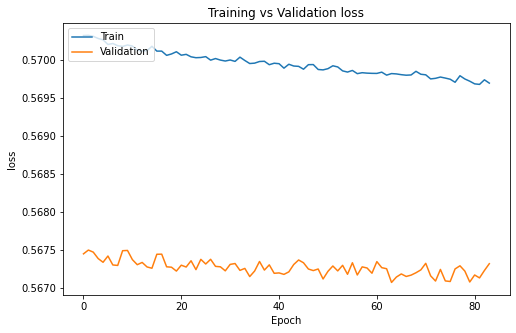

In [ ]:
plot_hist(hist2.history, xsize=8, ysize=5)

The loss curve shows that there is significant difference between train and validation.

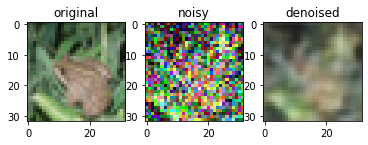

In [ ]:
decoded_noisy_imgs2 = autoencoder.predict(x_test_noisy)

idx = 4
plt.subplot(1,3,1)
plt.imshow(x_test[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(x_test_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(decoded_noisy_imgs2[idx])
plt.title('denoised')
plt.show()

In [ ]:
print('Original vs noisy MAE = \t', round(mae_images(x_test, x_test_noisy), 5))
print('Original vs denoised MAE = \t', round(mae_images(x_test, decoded_noisy_imgs2), 5))

Original vs noisy MAE = 	 0.20257
Original vs denoised MAE = 	 0.06519


<a id = "cell_report"></a>
## 5. Experiments Report

strenghths: takes less time to training the models.
weakness: the quality of predicted images still need improving.
As shown below, the 2 models have simialr performance in terms of the MAE comparision, model 1 is slighltly better than model 2. Additioanlly, according to loss curve, model 1 shows minimal difference between train and validation, model 2 shows significant difference between train and validation. Therefore, model 1 will be recommeded as the final model because it is more practical. 

<a id = "cell_report"></a>
## 6. References


1. Kumar.T. 2020. Autoencoder Denoising Image (MNIST/Cifar10). Retrived from<https://www.kaggle.com/tarunkr/autoencoder-denoising-image-mnist-cifar10>

2. Fijalkowski.B. 2019. A denoising autoencoder for CIFAR dataset(s). Retrived from<https://codahead.com/blog/a-denoising-autoencoder-for-cifar-datasets>

3. Brownlee.J. 2020. How to Develop a CNN From Scratch for CIFAR-10 Photo Classification. Retrived from<https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/>